In [38]:
!gdown 1cLcYZOEA81nNZbjNaqzLZhg6xM0ltBhw

Downloading...
From: https://drive.google.com/uc?id=1cLcYZOEA81nNZbjNaqzLZhg6xM0ltBhw
To: /content/twitter_sentiment_data.csv
100% 6.57M/6.57M [00:00<00:00, 121MB/s]


In [39]:
!pip install pydataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

In [68]:
 df=pd.read_csv('twitter_sentiment_data.csv')


In [67]:
df.shape[0]

43943

In [42]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [43]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

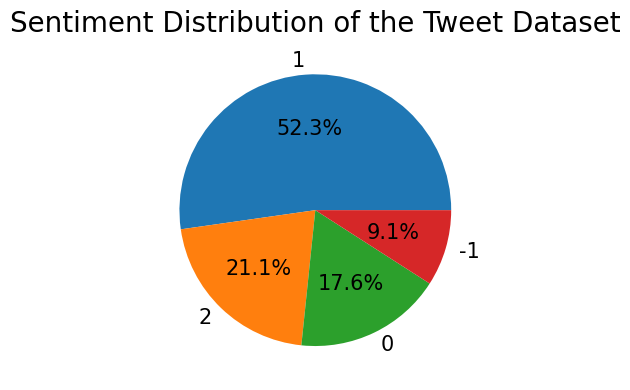

In [44]:
#Distribution of sentiment
plt.figure(figsize = (4, 4))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

In [45]:
df.sentiment.value_counts()

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

In [46]:
#data pre-processing
# separate the messages column for transformation.
dfTweets = df["message"]

In [70]:
len(dfTweets)

43943

In [47]:
#Tokenization
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)
        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [48]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

In [71]:
len(tokenizedLi)

43943

In [49]:
#Stopword Removal
# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
   stopWords = set(stopwords.words('english'))
   shorterSentences = []  # Declare empty array of sentences.
   for sentence in tokenList:
     shorterSentence = []  # Declare empty array of words in single sentence.
     for word in sentence:
       if word not in stopWords:
         word = word.strip()
         if (len(word) > 1 and word.isdigit() == False):
           shorterSentence.append(word)
     shorterSentences.append(shorterSentence)
   return shorterSentences            



    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


In [72]:
len(tokenizedNoStopLi)

43943

In [74]:

# Stemming
def stemWords(sentenceArrays):
  ps = PorterStemmer()
  stemmedSentences = []
  for sentenceArray in sentenceArrays:
    stemmedArray = []  # Declare empty array of words.
    for word in sentenceArray:
      stemmedArray.append(ps.stem(word))
    # Convert array back to sentence of stemmed words.
    delimeter = ' '
    sentence = delimeter.join(stemmedArray)
    # Append stemmed sentence to list of sentences.
    stemmedSentences.append(sentence)
  return stemmedSentences

In [75]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


In [76]:
len(stemmedLi)

43943

In [77]:
#Vectorization
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [78]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

In [79]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


In [80]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [81]:
vectorizedTweets.shape

(43943, 67195)

In [82]:
len(stemmedLi)

43943

In [83]:
#Bi-Gram
#Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [84]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

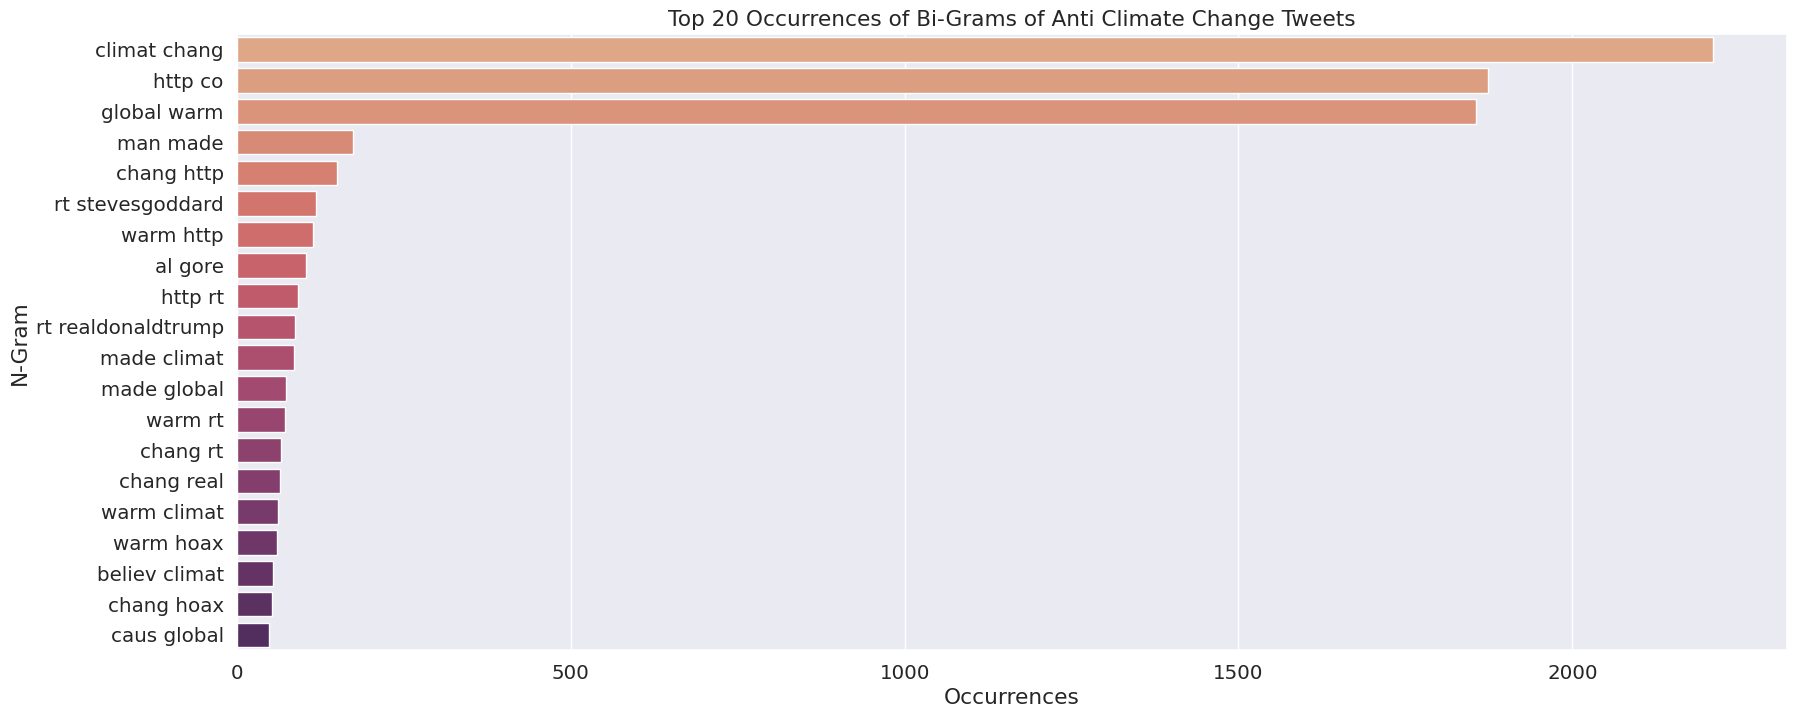

In [85]:
#Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

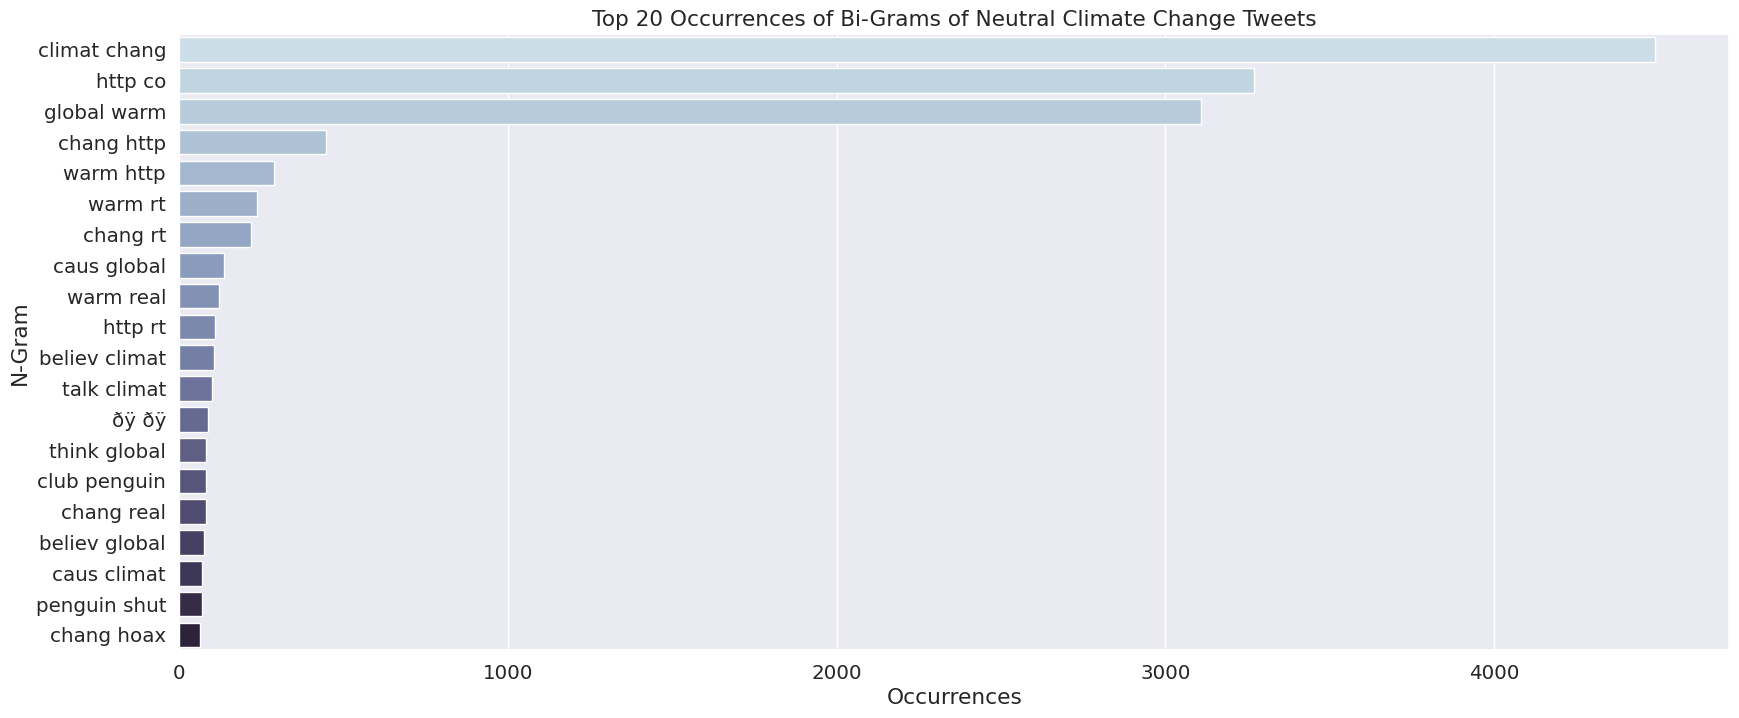

In [86]:
#Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

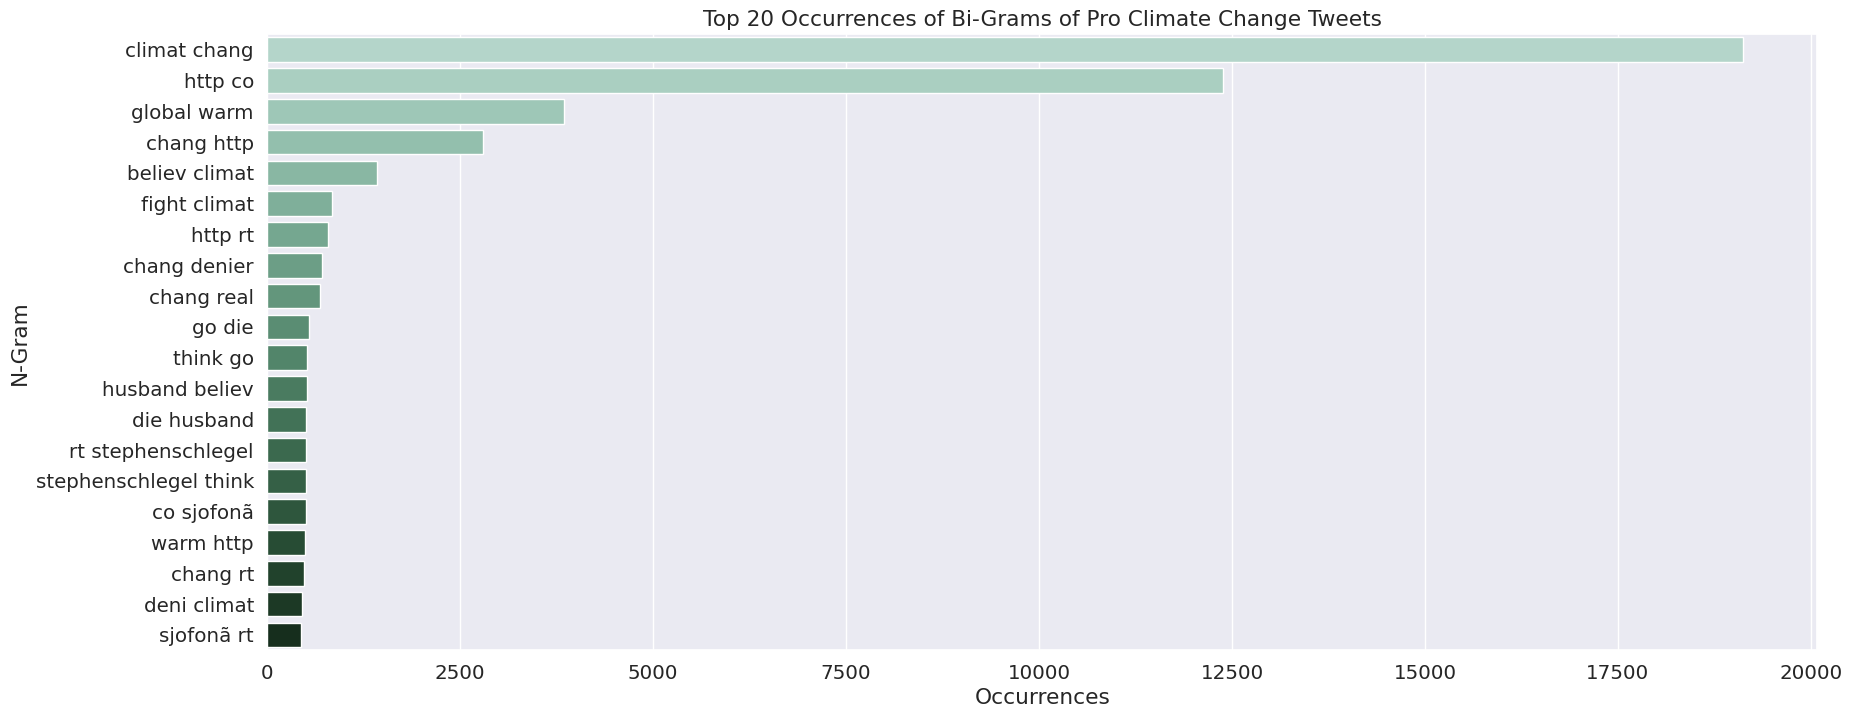

In [87]:
#Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")


***N-Gram (Sentiment: 2)
          N-Gram  Occurrences
0        http co        10199
1   climat chang         8102
2     chang http         2000
3    global warm         1196
4   fight climat          356
5      warm http          350
6   donald trump          269
7   trump climat          248
8        http rt          244
9   scott pruitt          218
10     rt thehil          208
11     epa chief          150
12   pari climat          129
13  tackl climat          126
14    say climat          126
15         co rt          126
16      say http          126
17    due climat          122
18     news http          121
19  chang polici          118


<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

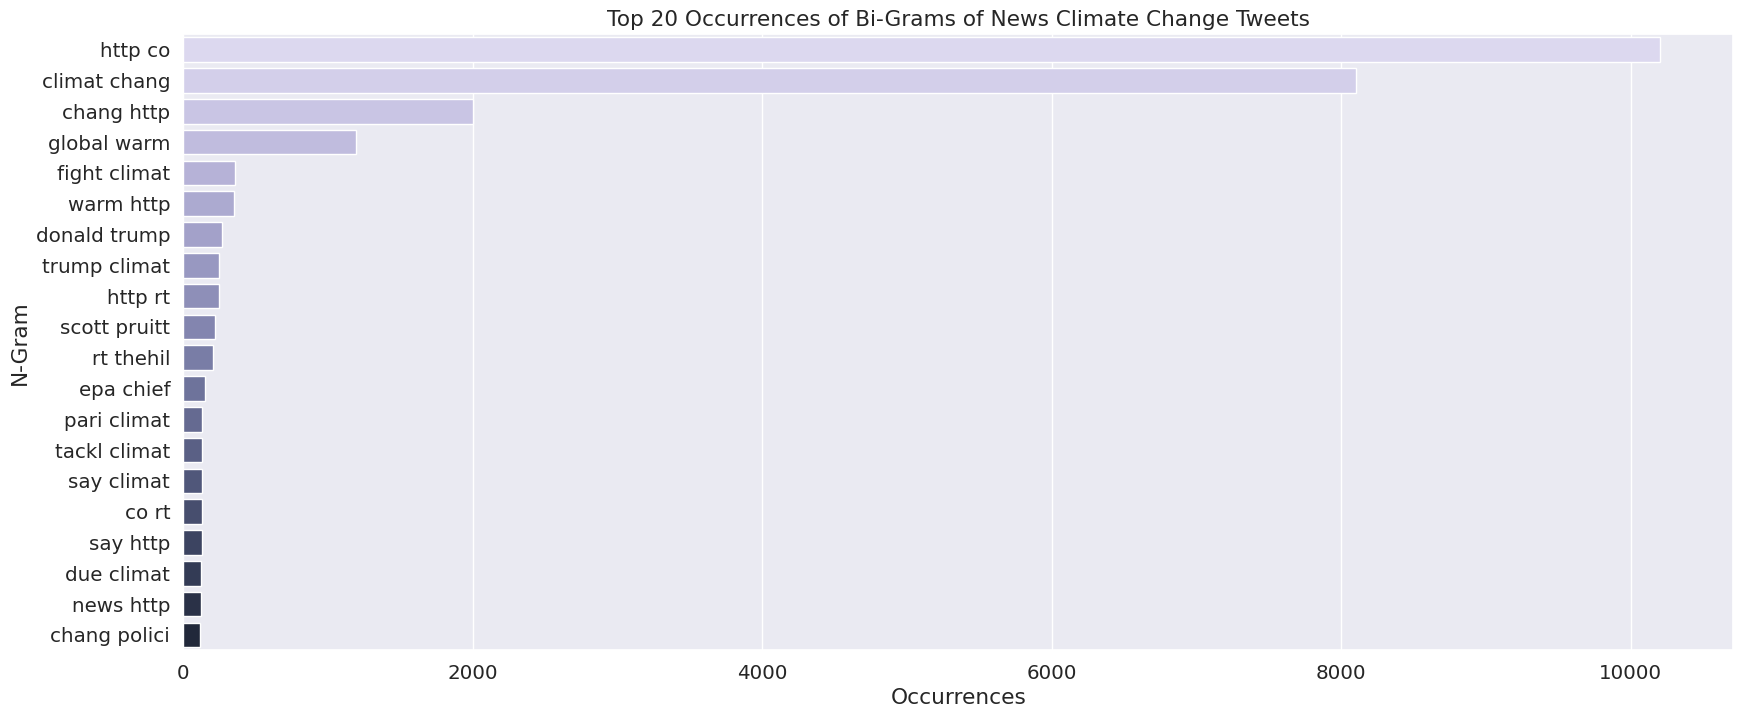

In [88]:
#Top 20 Occurrences of Bi-Grams of Factual Climate Change Tweets (2)
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1")

In [89]:
#Tri-Grams
SIZE = 3


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

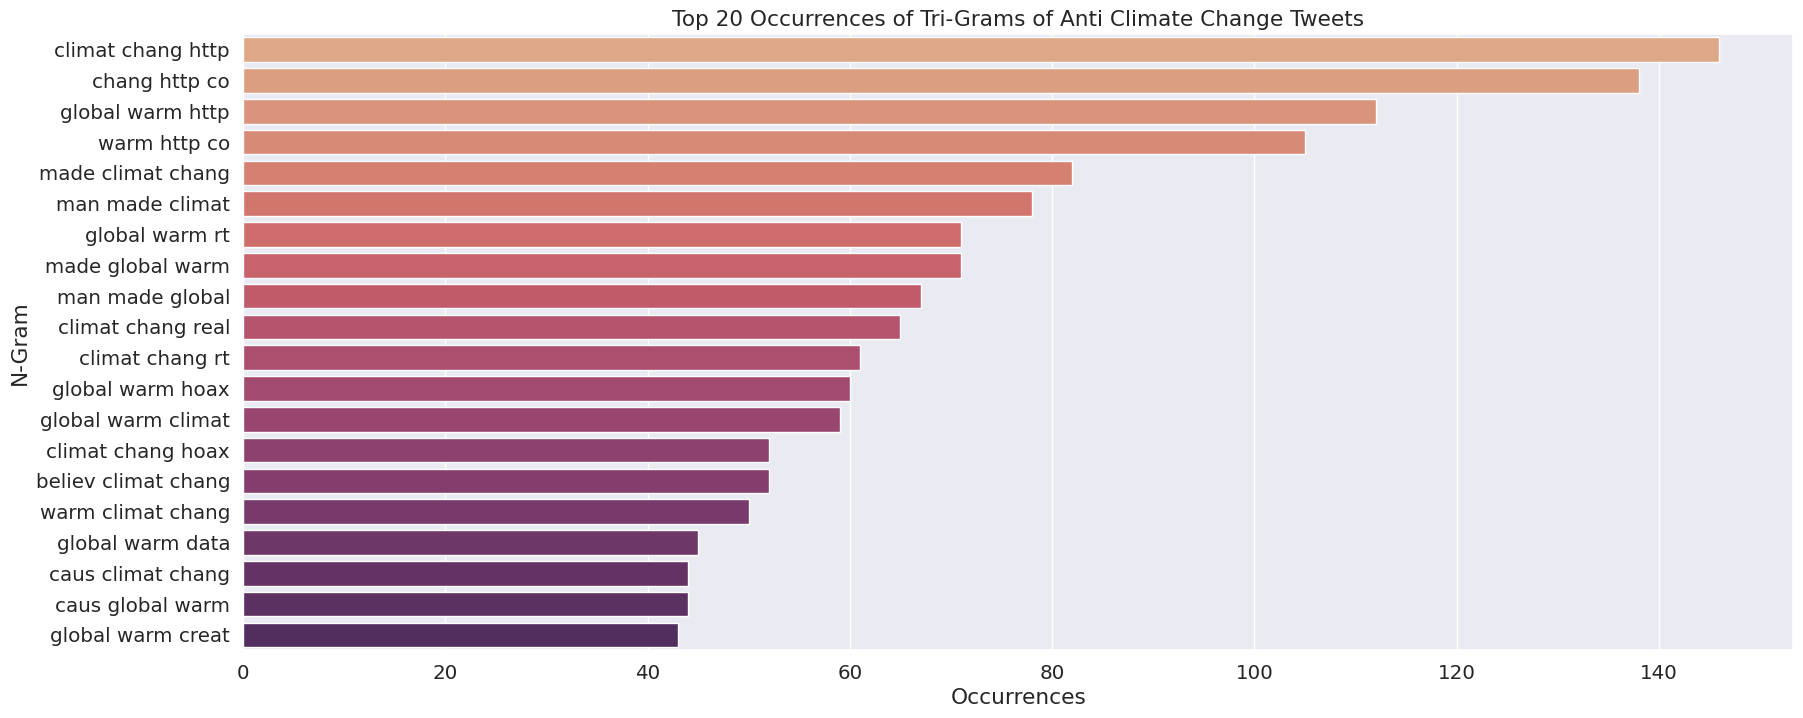

In [90]:
#Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

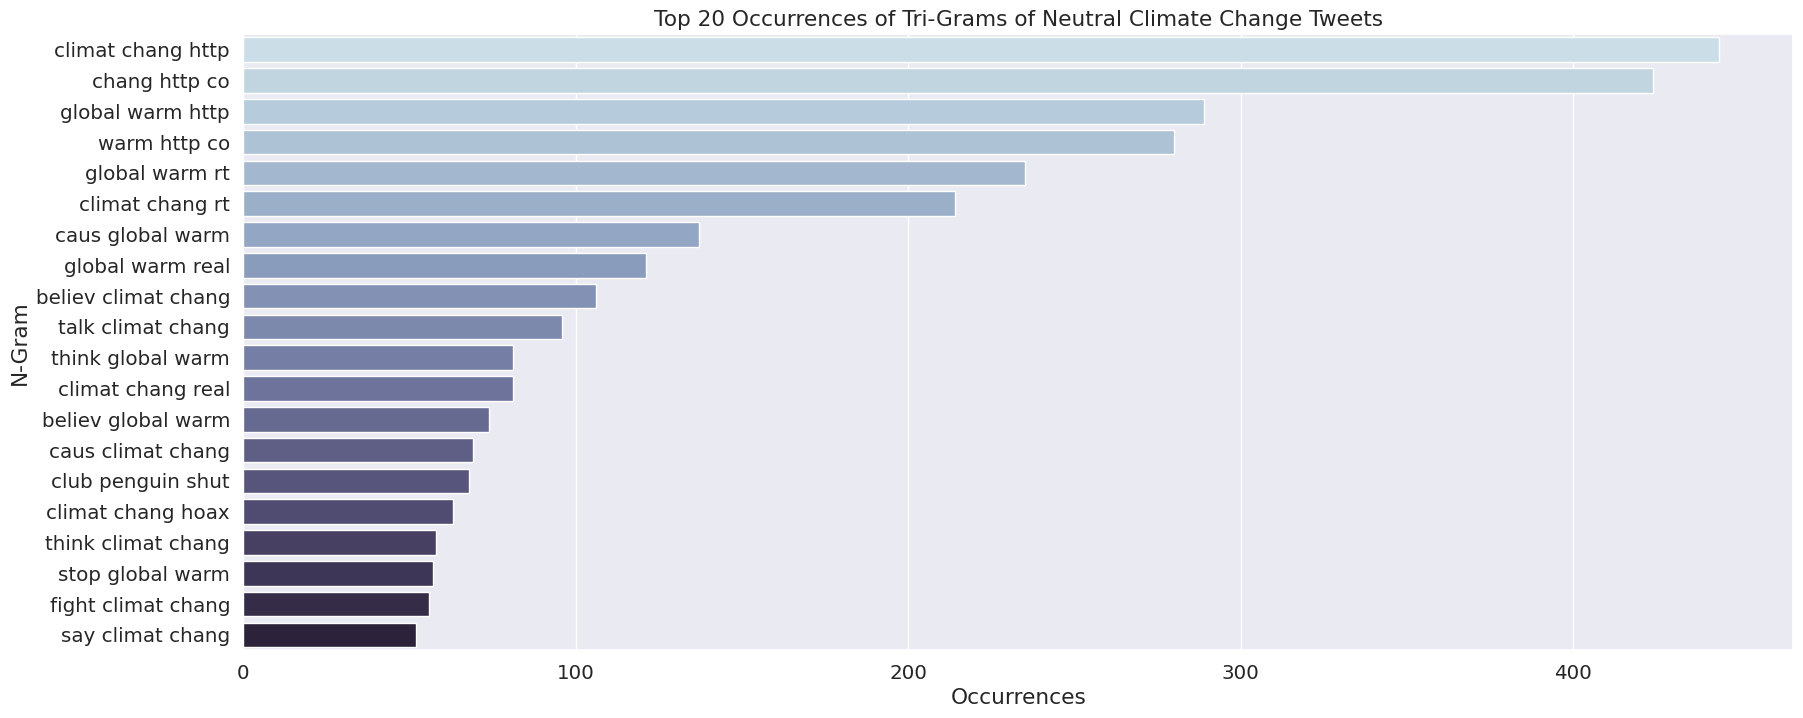

In [91]:
#Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

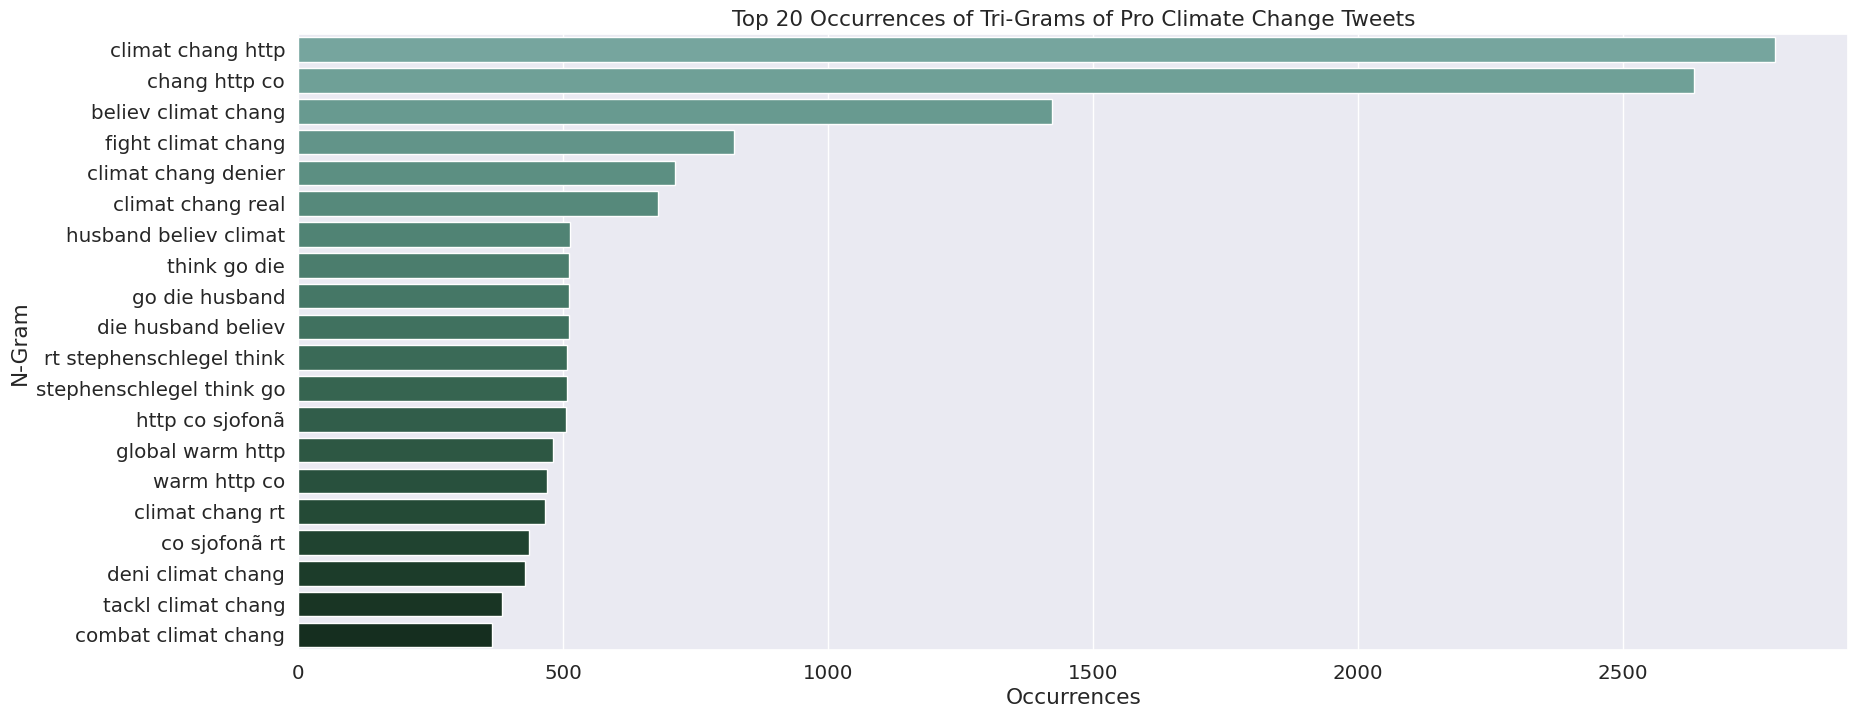

In [92]:
#Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


***N-Gram (Sentiment: 2)
                    N-Gram  Occurrences
0        climat chang http         1998
1            chang http co         1964
2       fight climat chang          355
3         global warm http          348
4             warm http co          346
5       trump climat chang          244
6               http co rt          126
7       tackl climat chang          125
8         say climat chang          124
9         due climat chang          122
10            news http co          121
11             say http co          121
12       pari climat chang          117
13     climat chang polici          116
14     action climat chang           96
15     effect climat chang           88
16      climat chang could           82
17           studi http co           81
18  climat chang agreement           80
19       talk climat chang           79


<Axes: title={'center': 'Top 20 Occurrences of Tri-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

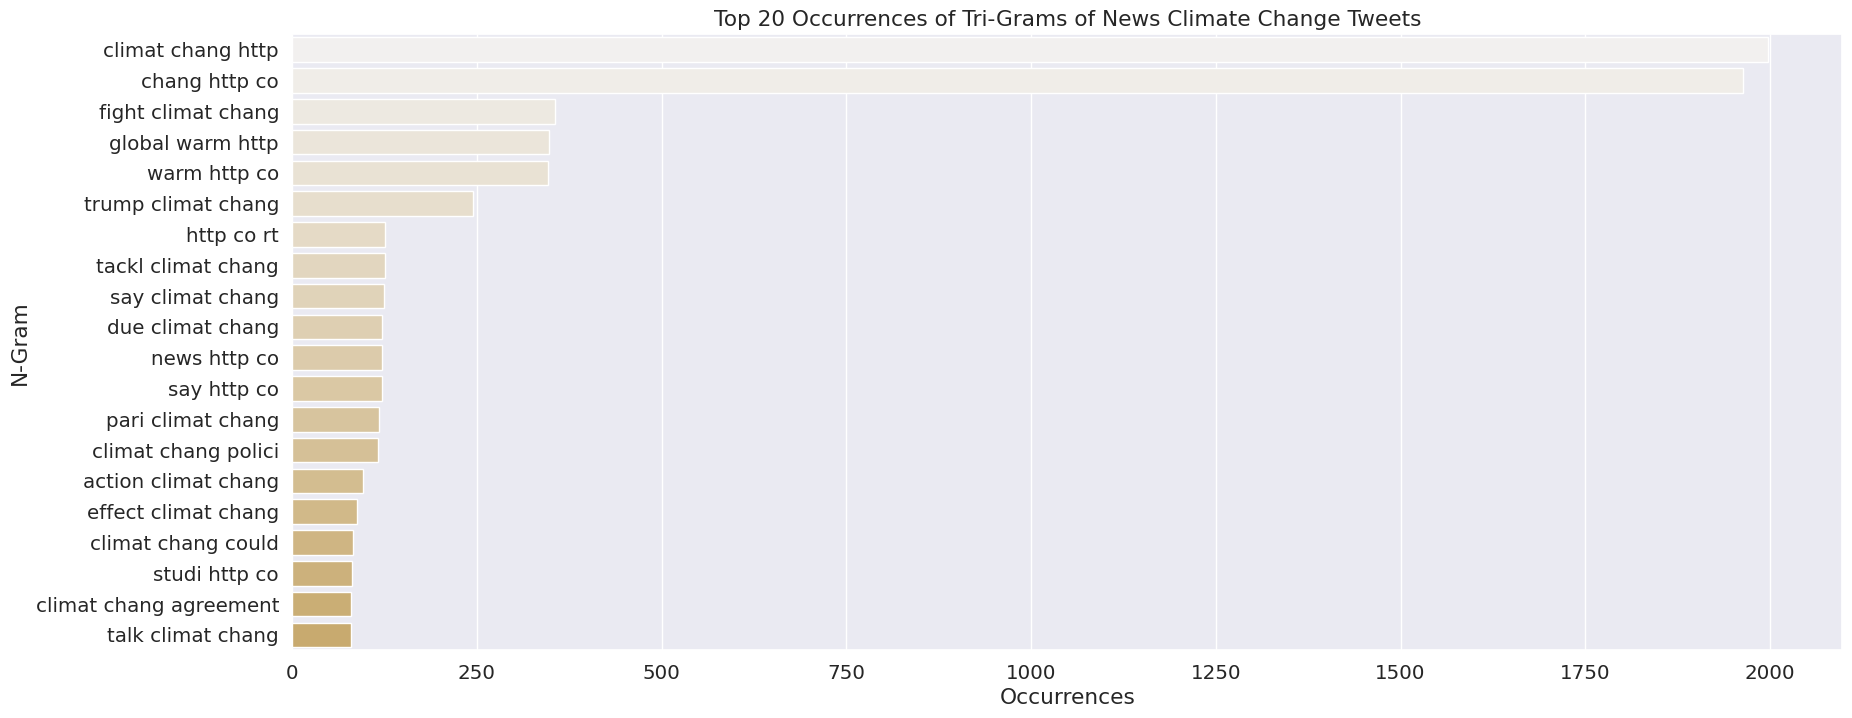

In [93]:
#Top 20 Occurrences of Tri-Grams of Factual Climate Change Tweets (2)
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")

In [94]:
df.head()

,sentiment,message,tweetid,transformedTweets
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840,tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641,rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chan...
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256,fabul leonardo dicaprio film climat chang brilliant watch http co 7rv6brmxjw via youtub
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904,rt mick_fan watch amaz documentari leonardodicaprio climat chang think thisã http co k...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153,rt cnaliv pranita biswasi lutheran odisha give testimoni effect climat chang amp natur...


In [95]:
df_train=df

In [107]:
# Preprocess the data
X = df_train['transformedTweets']
y = df_train['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [108]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  264934


In [109]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [110]:
# Train the model
#Naive Bayesian
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
# model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

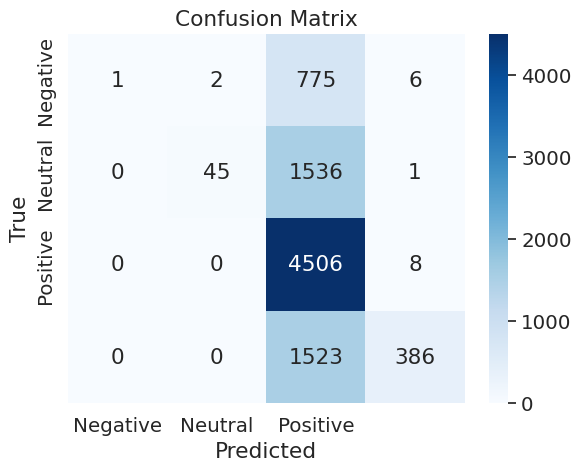

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset and create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred1)

# Define the labels for the confusion matrix
labels = ["Negative", "Neutral", "Positive"]

# Create the heatmap using seaborn
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Add labels and title to the plot
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Display the plot
plt.show()


In [113]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred1 ))
from sklearn.metrics import classification_report

# Assume y_true and y_pred are the true and predicted labels, respectively
print(classification_report(y_test, y_pred1))

0.5618386619638184
              precision    recall  f1-score   support

          -1       1.00      0.00      0.00       784
           0       0.96      0.03      0.06      1582
           1       0.54      1.00      0.70      4514
           2       0.96      0.20      0.33      1909

    accuracy                           0.56      8789
   macro avg       0.87      0.31      0.27      8789
weighted avg       0.75      0.56      0.44      8789



In [117]:
!gdown 1A3u5bwpuXk4pxhA_kGMNI94HakorZ6e3

Downloading...
From: https://drive.google.com/uc?id=1A3u5bwpuXk4pxhA_kGMNI94HakorZ6e3
To: /content/PreProcessedNLP.csv
100% 30.3M/30.3M [00:01<00:00, 24.9MB/s]


In [119]:
df_test = pd.read_csv('PreProcessedNLP.csv',lineterminator='\n')

In [120]:
df_test.head()

,conversation_id,created_at,text,lang\r,text1,processed_text,LemmatizeText
0,23160,2006-08-29T01:52:30.000Z,reading the economist and looking forward to global warming.,en\r,reading the economist and looking forward to global warming.,reading economist looking forward global warming,reading economist looking forward global warming
1,57868,2006-11-07T02:46:52.000Z,Sitting outside on my patio in a t-shirt in sf in nov. Who says there's global warming,en\r,Sitting outside on my patio in a t-shirt in sf in nov. Who says there's global warming,sitting outside patio shirt sf nov says global warming,sitting outside patio shirt sf nov say global warming
2,304553,2006-11-27T14:27:43.000Z,"Name drop alert: listening to Tony Blair, at work offices, talking about climate chang...",en\r,"Name drop alert: listening to Tony Blair, at work offices, talking about climate chang...",name drop alert listening tony blair work offices talking climate change tall,name drop alert listening tony blair work office talking climate change tall
3,454763,2006-11-29T23:21:04.000Z,Cannot be held responsible for global warming but will admit the opium trade.,en\r,Cannot be held responsible for global warming but will admit the opium trade.,cannot held responsible global warming admit opium trade,cannot held responsible global warming admit opium trade
4,971753,2006-12-11T22:08:14.000Z,"Recommending people to watch ""An Inconvenient Truth"" movie about climate change and gl...",en\r,"Recommending people to watch ""An Inconvenient Truth"" movie about climate change and gl...",recommending people watch inconvenient truth movie climate change global warming,recommending people watch inconvenient truth movie climate change global warming


In [122]:
df_test.shape[0]

76215

In [123]:
df_train.shape[0]

43943

In [125]:
# Test the model
X_test = df_test['LemmatizeText'][:8789]
# Vectorize the test data using the same vectorizer
X_test_vec = vectoriser.transform(X_test)

# Predict the labels for the test data
y_pred = BNBmodel.predict(X_test_vec)

# Print the classification report to see the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       784
           0       0.00      0.00      0.00      1582
           1       0.51      1.00      0.68      4514
           2       0.00      0.00      0.00      1909

    accuracy                           0.51      8789
   macro avg       0.13      0.25      0.17      8789
weighted avg       0.26      0.51      0.35      8789



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
# Get the predicted label of the first tweet in X_test
for i in range(0,5):
  tweet_index =i
  predicted_label = y_pred[tweet_index]
  print(f"Predicted label of the tweet: {predicted_label}")
  print("Text  ")
  print(df_test['LemmatizeText'][i])






Predicted label of the tweet: 1
Text  
reading economist looking forward global warming
Predicted label of the tweet: 1
Text  
sitting outside patio shirt sf nov say global warming
Predicted label of the tweet: 1
Text  
name drop alert listening tony blair work office talking climate change tall
Predicted label of the tweet: 1
Text  
cannot held responsible global warming admit opium trade
Predicted label of the tweet: 1
Text  
recommending people watch inconvenient truth movie climate change global warming


In [114]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
# model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)
train_acc = SVCmodel.score(X_train, y_train)


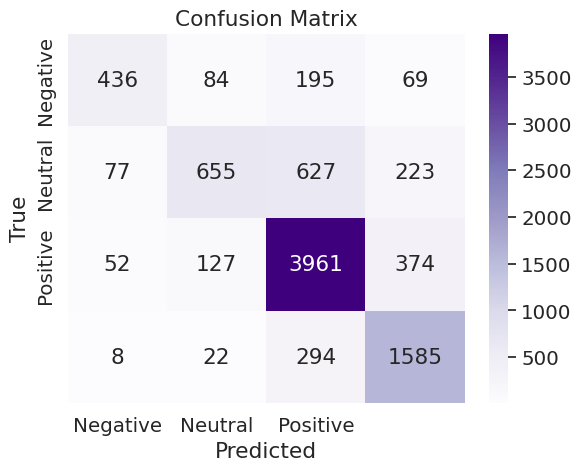

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd



# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)

# Define the labels for the confusion matrix
labels = ["Negative", "Neutral", "Positive"]

# Create the heatmap using seaborn
sns.heatmap(conf_matrix, annot=True, cmap="Purples", fmt="d", xticklabels=labels, yticklabels=labels)

# Add labels and title to the plot
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Display the plot
plt.show()


In [116]:
print(accuracy_score(y_test,y_pred2 ))
# print(train_acc)
from sklearn.metrics import classification_report

# Assume y_true and y_pred are the true and predicted labels, respectively
print(classification_report(y_test,y_pred2))

0.7551484810558653
              precision    recall  f1-score   support

          -1       0.76      0.56      0.64       784
           0       0.74      0.41      0.53      1582
           1       0.78      0.88      0.83      4514
           2       0.70      0.83      0.76      1909

    accuracy                           0.76      8789
   macro avg       0.75      0.67      0.69      8789
weighted avg       0.75      0.76      0.74      8789



In [134]:
# Test the model
X_test = df_test['LemmatizeText'][:8789]
# Vectorize the test data using the same vectorizer
X_test_vec = vectoriser.transform(X_test)

# Predict the labels for the test data
y_pred = SVCmodel.predict(X_test_vec)

# Print the classification report to see the performance of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.10      0.08      0.09       784
           0       0.18      0.30      0.23      1582
           1       0.51      0.45      0.48      4514
           2       0.22      0.18      0.20      1909

    accuracy                           0.33      8789
   macro avg       0.25      0.25      0.25      8789
weighted avg       0.35      0.33      0.34      8789



In [135]:
# Get the predicted label of the first tweet in X_test
for i in range(0,5):
  tweet_index =i
  predicted_label = y_pred[tweet_index]
  print(f"Predicted label of the tweet: {predicted_label}")
  print("Text  ")
  print(df_test['LemmatizeText'][i])






Predicted label of the tweet: 2
Text  
reading economist looking forward global warming
Predicted label of the tweet: 1
Text  
sitting outside patio shirt sf nov say global warming
Predicted label of the tweet: 1
Text  
name drop alert listening tony blair work office talking climate change tall
Predicted label of the tweet: -1
Text  
cannot held responsible global warming admit opium trade
Predicted label of the tweet: 1
Text  
recommending people watch inconvenient truth movie climate change global warming


In [139]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =0)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  264259


In [140]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
# model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

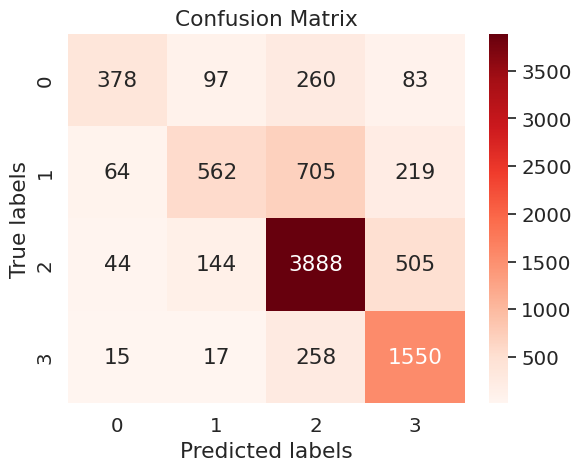

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true: true labels, y_pred: predicted labels
cm = confusion_matrix(y_test, y_pred3)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")

# Set the axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Display the plot
plt.show()


In [142]:
from sklearn.metrics import accuracy_score

In [143]:
print(accuracy_score(y_test,y_pred3 ))

0.725679827056548


In [144]:
from sklearn.metrics import classification_report

# Assume y_true and y_pred are the true and predicted labels, respectively
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

          -1       0.75      0.46      0.57       818
           0       0.69      0.36      0.47      1550
           1       0.76      0.85      0.80      4581
           2       0.66      0.84      0.74      1840

    accuracy                           0.73      8789
   macro avg       0.71      0.63      0.65      8789
weighted avg       0.73      0.73      0.71      8789



In [146]:
# Test the model
X_test = df_test['LemmatizeText'][:8789]
# Vectorize the test data using the same vectorizer
X_test_vec = vectoriser.transform(X_test)

# Predict the labels for the test data
y_pred_log = LRmodel.predict(X_test_vec)

# Print the classification report to see the performance of the model
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

          -1       0.09      0.07      0.08       818
           0       0.18      0.36      0.24      1550
           1       0.52      0.45      0.49      4581
           2       0.22      0.12      0.16      1840

    accuracy                           0.33      8789
   macro avg       0.25      0.25      0.24      8789
weighted avg       0.36      0.33      0.34      8789



In [147]:
# Get the predicted label of the first tweet in X_test
for i in range(0,5):
  tweet_index =i
  predicted_label = y_pred_log[tweet_index]
  print(f"Predicted label of the tweet: {predicted_label}")
  print("Text  ")
  print(df_test['LemmatizeText'][i])






Predicted label of the tweet: 0
Text  
reading economist looking forward global warming
Predicted label of the tweet: 0
Text  
sitting outside patio shirt sf nov say global warming
Predicted label of the tweet: 1
Text  
name drop alert listening tony blair work office talking climate change tall
Predicted label of the tweet: 0
Text  
cannot held responsible global warming admit opium trade
Predicted label of the tweet: -1
Text  
recommending people watch inconvenient truth movie climate change global warming
